# Tutorial1: Axolotl Brain Regeneration Process: STIFT Achieves Superior Biological Variation Pattern Preservation

This tutorial demonstrate STIFT can remove batch effects while preserving biological variation in development or regeneration process, using the integration of axolotl brain regeneration process data as an example. The data can be downloaded from [ARTISTA: Axolotl Regenerative Telencephalon Interpretation via Spatiotemporal Transcriptomic Atlas](https://db.cngb.org/stomics/artista/).

## Preprocess

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from typing import List, Tuple, Optional
from anndata import AnnData
import scanpy as sc
import scipy.sparse as sp
import sklearn.neighbors
import networkx as nx
import scipy
import ot
import anndata as ad
import scipy.linalg

import STIFT

In [2]:
# adata0 = sc.read_h5ad("/project/Stat/s1155202253/myproject/data/ARTISTA/Control_Juv.h5ad")
adata1 = sc.read_h5ad("/project/Stat/s1155202253/myproject/data/ARTISTA/2DPI_1.h5ad")
adata2 = sc.read_h5ad("/project/Stat/s1155202253/myproject/data/ARTISTA/5DPI_1.h5ad")
adata3 = sc.read_h5ad("/project/Stat/s1155202253/myproject/data/ARTISTA/10DPI_1.h5ad")
adata4 = sc.read_h5ad("/project/Stat/s1155202253/myproject/data/ARTISTA/15DPI_1.h5ad")
adata5 = sc.read_h5ad("/project/Stat/s1155202253/myproject/data/ARTISTA/20DPI_1.h5ad")
adata6 = sc.read_h5ad("/project/Stat/s1155202253/myproject/data/ARTISTA/30DPI.h5ad")
adata7 = sc.read_h5ad("/project/Stat/s1155202253/myproject/data/ARTISTA/60DPI.h5ad")
# in adata3, delete (adata3.obsm["spatial"][:, 0]>7000)
adata3 = adata3[adata3.obsm["spatial"][:, 0]<7000, :]
section_ids = ['2DPI', '5DPI', '10DPI','15DPI','20DPI','30DPI', '60DPI']
adata_list = [adata1, adata2, adata3, adata4, adata5, adata6, adata7]

# rename adata.obs["Annotation"] to "annotation"

for i, adata in enumerate(adata_list):
    # Add a unique identifier to each observation
    adata.obs['batch_names'] = section_ids[i]
    
    # Create a unique index for each observation
    adata.obs['unique_obs'] = adata.obs['batch_names'] + '_' + adata.obs.index.astype(str)
    
    # Set the unique index as the new index
    adata.obs.set_index('unique_obs', inplace=True)
    
    # Your existing code
    adata.obs["annotation"] = adata.obs["Annotation"]
    del adata.obs["Annotation"]
    adata.layers["count"] = adata.layers["counts"]
    del adata.layers["counts"]
    adata.X = adata.layers["count"]

/tmp/ipykernel_3562760/1850602435.py:18: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['batch_names'] = section_ids[i]


Let's quickly examine what the data looks like.

/tmp/ipykernel_3562760/3665718941.py:13: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(coordinatesA[indices, 0], coordinatesA[indices, 1], s=2, c=color_list[j], label=ann)  # Flip Y-axis by using -


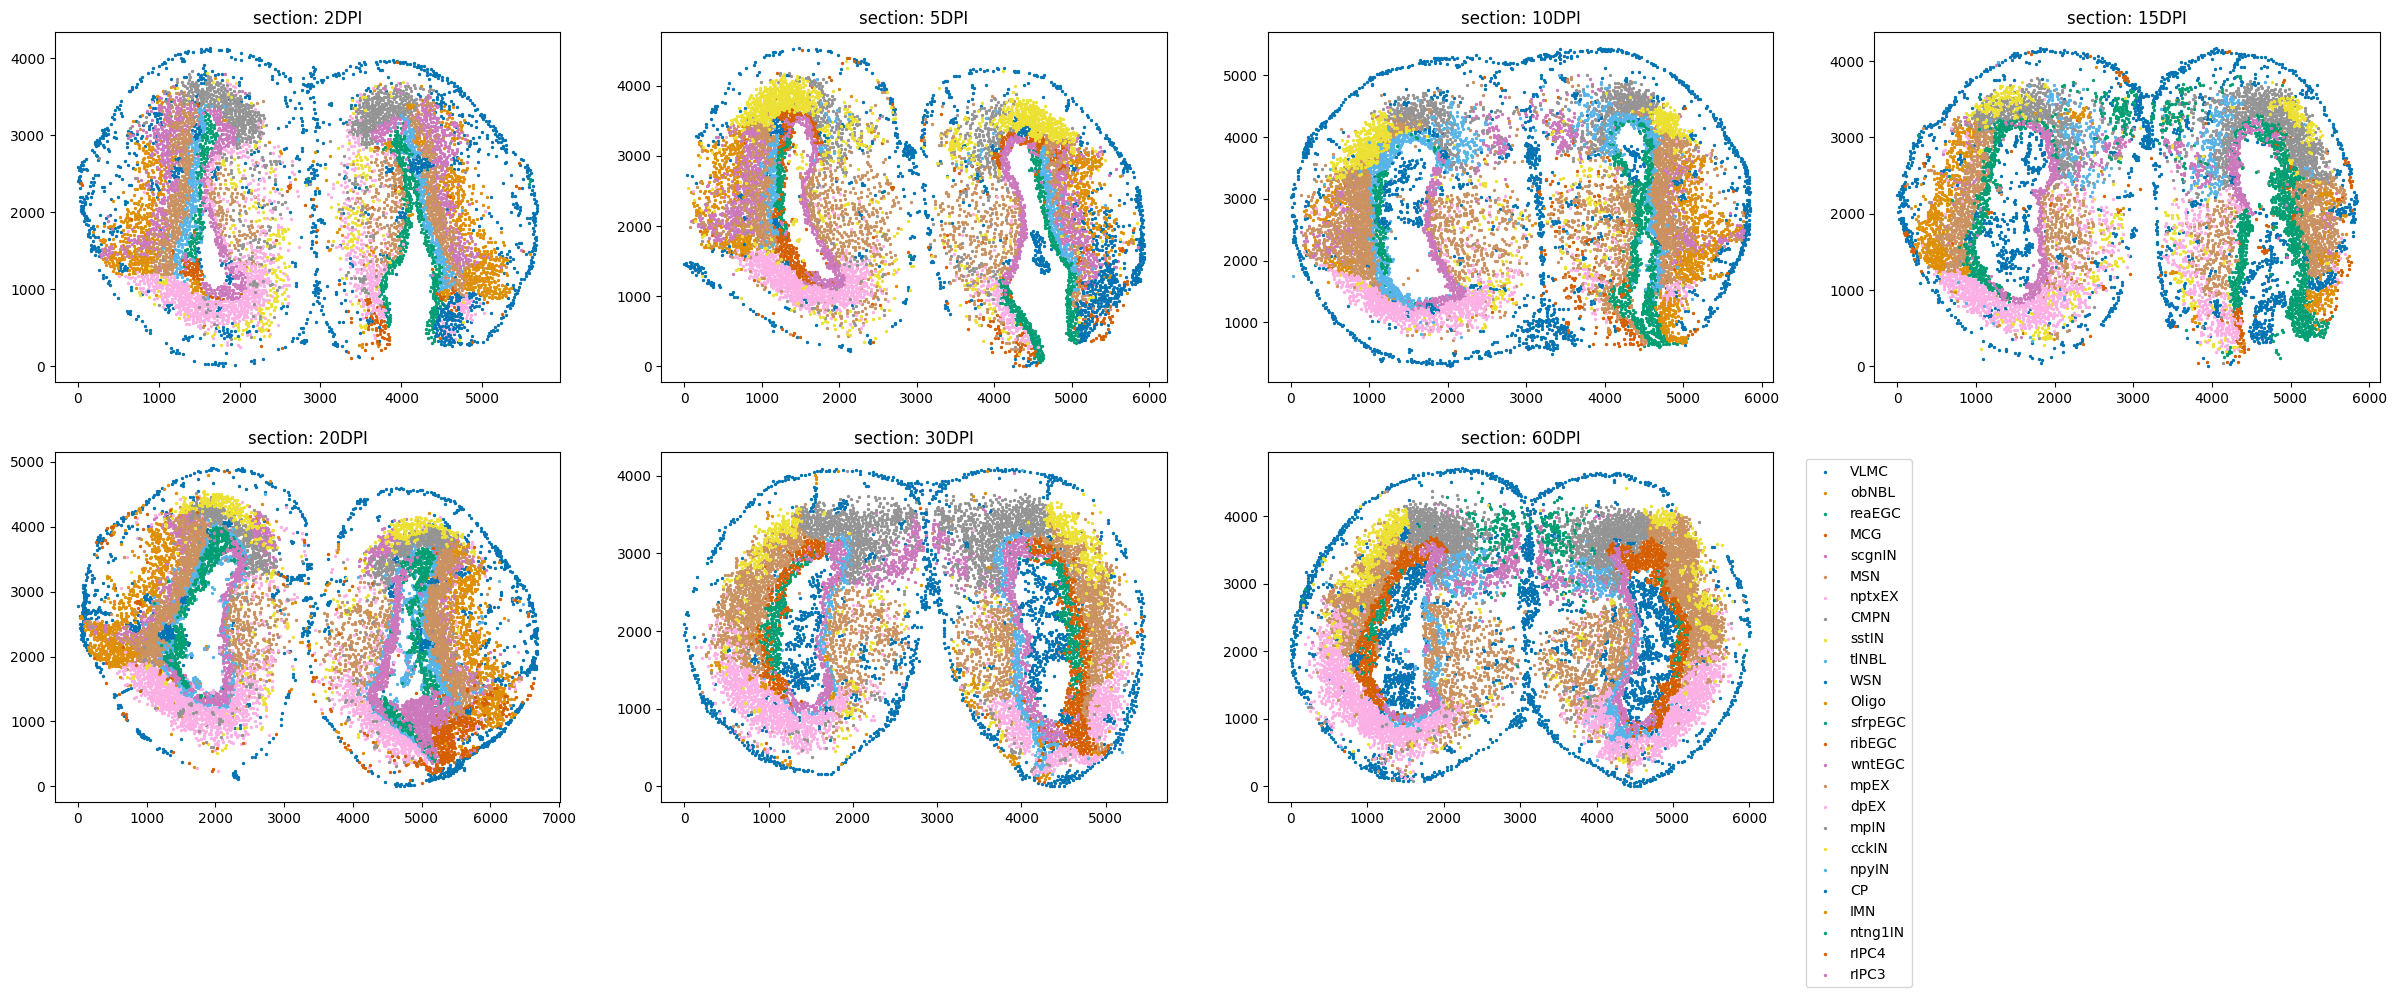

In [3]:
import seaborn as sns

color_list = sns.color_palette("colorblind" ,30)
celltype_list = ad.concat(adata_list).obs["annotation"].unique()
adata_concat = None

plt.figure(figsize=(30, 10))
for i, adata in enumerate((adata_list)):
    coordinatesA = adata.obsm['spatial'].copy()
    plt.subplot(2, 4, i+1)
    for j, ann in enumerate(celltype_list):
        indices = adata.obs["annotation"] == ann
        plt.scatter(coordinatesA[indices, 0], coordinatesA[indices, 1], s=2, c=color_list[j], label=ann)  # Flip Y-axis by using -
    plt.title("section: " + section_ids[i])

plt.legend(bbox_to_anchor=(1.05, 1), loc='best')

## Step1: Pre-alignment

In this step, we want to pre-align slices from adjacent time points.

In [3]:
import matplotlib.pyplot as plt

Pi_list = []
xi_list = []
errs_list = []

for i in range(len(section_ids)-1):
    Pi, xi, errs = STIFT.align(adata_list[i], adata_list[i+1], alpha=0.2, gamma=1, epsilon=0.1, max_iter=500, 
                    balanced=False, use_gpu=True, normalize_xi=True, check_convergence=True, normalize_counts=True, normalize_spatial=True)
    Pi_list.append(Pi)
    xi_list.append(xi)
    torch.cuda.empty_cache()

mapping_AB_list = []
mapping_BA_list = []

for Pi in Pi_list:
    mapping_AB, mapping_BA = STIFT.get_mapping(Pi)
    mapping_AB_list.append(mapping_AB)
    mapping_BA_list.append(mapping_BA)

Iteration: 0
Iteration: 5
Iteration: 10
Iteration: 15
Iteration: 20
Iteration: 25
Iteration: 30
Iteration: 35
Iteration: 40
Iteration: 45
Iteration: 50
Iteration: 55
Iteration: 60
Iteration: 65
Iteration: 70
Iteration: 75
Iteration: 80
Iteration: 85
Iteration: 90
Iteration: 95
Iteration: 100
Iteration: 105
Iteration: 110
Iteration: 115
Iteration: 120
Iteration: 125
Iteration: 130
Iteration: 135
Iteration: 140
Iteration: 145
Iteration: 150
Iteration: 155
Iteration: 160
Iteration: 165
Iteration: 170
Iteration: 175
Iteration: 180
Iteration: 185
Iteration: 190
Iteration: 195
Iteration: 200
Iteration: 205
Iteration: 210
Iteration: 215
Iteration: 220
Iteration: 225
Iteration: 230
Iteration: 235
Iteration: 240
Iteration: 245
Iteration: 250
Iteration: 255
Iteration: 260
Iteration: 265
Iteration: 270
Iteration: 275
Iteration: 280
Iteration: 285
Iteration: 290
Iteration: 295
Iteration: 300
Iteration: 305
Iteration: 310
Iteration: 315
Iteration: 320
Iteration: 325
Iteration: 330
Iteration: 335
It

## Step2: Construct spatiotemporal matrix

In this step, we want to construct an integrated spatiotemporal matrix.

In [5]:
for section_id in section_ids:
    print(section_id)
    adata = adata_list[section_ids.index(section_id)]

    STIFT.Cal_Spatial_Net(adata, model="KNN", k_cutoff=10)
    
    # Normalization
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=12000) #ensure enough common HVGs in the combined matrix

    adata_list[section_ids.index(section_id)] = adata[:, adata.var['highly_variable']]

adata_list = STIFT.get_family_information(adata_list, section_ids, Pi_list, k=10)
adata_concat, adj_concat = STIFT.create_ST2_adj_matrix(adata_list, section_ids)

2DPI
------Calculating spatial graph...
The graph contains 76680 edges, 7668 cells.
10.0000 neighbors per cell on average.


/stat_Lin_Group/s1155202253/miniconda3/envs/env_202408/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:75: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


5DPI
------Calculating spatial graph...
The graph contains 81060 edges, 8106 cells.
10.0000 neighbors per cell on average.


/stat_Lin_Group/s1155202253/miniconda3/envs/env_202408/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:75: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


10DPI
------Calculating spatial graph...
The graph contains 94360 edges, 9436 cells.
10.0000 neighbors per cell on average.


/stat_Lin_Group/s1155202253/miniconda3/envs/env_202408/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:75: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


15DPI
------Calculating spatial graph...
The graph contains 89960 edges, 8996 cells.
10.0000 neighbors per cell on average.


/stat_Lin_Group/s1155202253/miniconda3/envs/env_202408/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:75: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


20DPI
------Calculating spatial graph...
The graph contains 104620 edges, 10462 cells.
10.0000 neighbors per cell on average.


/stat_Lin_Group/s1155202253/miniconda3/envs/env_202408/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:75: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


30DPI
------Calculating spatial graph...
The graph contains 92520 edges, 9252 cells.
10.0000 neighbors per cell on average.


/stat_Lin_Group/s1155202253/miniconda3/envs/env_202408/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:75: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


60DPI
------Calculating spatial graph...
The graph contains 109640 edges, 10964 cells.
10.0000 neighbors per cell on average.


/stat_Lin_Group/s1155202253/miniconda3/envs/env_202408/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:75: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(
/stat_Lin_Group/s1155202253/miniconda3/envs/env_202408/lib/python3.9/site-packages/STIFT/STIFT.py:160: ImplicitModificationWarning: Setting element `.obsm['children']` of view, initializing view as actual.
  adata_list[i].obsm["children"] = topk_mapping_AB_list[i]
/stat_Lin_Group/s1155202253/miniconda3/envs/env_202408/lib/python3.9/site-packages/STIFT/STIFT.py:161: ImplicitModificationWarning: Setting element `.obsm['parents']` of view, initializing view as actual.
  adata_list[i+1].obsm["parents"] = topk_mapping_BA_list[i].T


## Step3: train GATE and triplet learning

In this step, we want to train graph attention autoencoder and apply triplet learning to get the integrated embeddings of spots.

In [6]:
adata_concat = STIFT.train_STIFT(adata_list=adata_list, adata_concat=adata_concat, hidden_dims=[512, 30], pre_n_epochs=1000, n_epochs=1000, lr=0.001, key_added='STIFT', gradient_clipping=5., margin=1.0, weight_decay=0.0001, verbose=False,
                    random_seed=666, device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu'))

Pretrain with STAGATE...


100%|██████████| 1000/1000 [02:49<00:00,  5.89it/s]


Train with STIFT...


  0%|          | 1/1000 [00:01<30:35,  1.84s/it]

loss:  0.5615414977073669 mse_loss:  0.3606005609035492 triplet_loss:  0.20094092190265656


 10%|█         | 101/1000 [00:20<09:39,  1.55it/s]

loss:  0.4092000722885132 mse_loss:  0.3742281198501587 triplet_loss:  0.03497196361422539


 20%|██        | 201/1000 [00:39<08:39,  1.54it/s]

loss:  0.40363553166389465 mse_loss:  0.37119412422180176 triplet_loss:  0.032441396266222


 30%|███       | 301/1000 [00:57<07:31,  1.55it/s]

loss:  0.3993043005466461 mse_loss:  0.3705969452857971 triplet_loss:  0.028707355260849


 40%|████      | 401/1000 [01:16<06:25,  1.55it/s]

loss:  0.3972371518611908 mse_loss:  0.3693932294845581 triplet_loss:  0.02784392610192299


 50%|█████     | 501/1000 [01:35<05:21,  1.55it/s]

loss:  0.3954737186431885 mse_loss:  0.36904168128967285 triplet_loss:  0.026432033628225327


 60%|██████    | 601/1000 [01:53<04:17,  1.55it/s]

loss:  0.3950643539428711 mse_loss:  0.36846664547920227 triplet_loss:  0.02659771405160427


 70%|███████   | 701/1000 [02:12<03:14,  1.54it/s]

loss:  0.3939846456050873 mse_loss:  0.36839520931243896 triplet_loss:  0.025589443743228912


 80%|████████  | 801/1000 [02:30<02:08,  1.55it/s]

loss:  0.3942002058029175 mse_loss:  0.368202805519104 triplet_loss:  0.02599738910794258


 90%|█████████ | 901/1000 [02:49<01:03,  1.55it/s]

loss:  0.39227035641670227 mse_loss:  0.3682844340801239 triplet_loss:  0.02398592047393322


100%|██████████| 1000/1000 [03:06<00:00,  5.36it/s]


## Result

Let's see the integrated spot embeddings from STIFT with ground truth annotation.

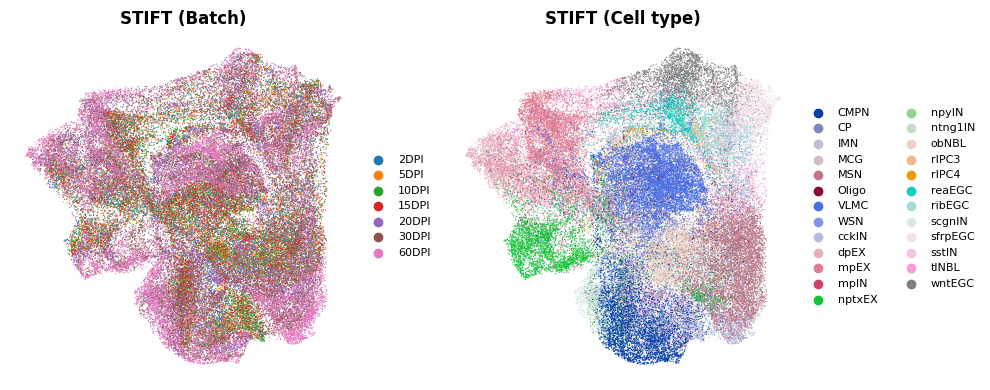

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
sc.pp.neighbors(adata_concat, use_rep='STIFT', random_state=66)
sc.tl.umap(adata_concat, random_state=66)

# Plot UMAP for each feature
sc.pl.umap(adata_concat, color='batch_names', ax=axs[0], show=False, title='STIFT (Batch)', 
           legend_loc='right margin', legend_fontweight='light', legend_fontsize=8, size=3)
sc.pl.umap(adata_concat, color='annotation', ax=axs[1], show=False, title='STIFT (Cell type)', 
           legend_loc='right margin', legend_fontweight='light', legend_fontsize=8, size=3)

# Customize each subplot
for ax in axs:
    ax.title.set_weight('bold')
    
    # Keep only left and bottom spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    ax.set_xlabel('')
    ax.set_ylabel('')
    
    legend = ax.get_legend()
    if legend:
        for text, patch in zip(legend.get_texts(), legend.get_patches()):
            patch.set_height(10)
            patch.set_width(10)
            patch.set_edgecolor('none')

plt.tight_layout()
plt.show()

Perform Louvain clustering on STIFT embeddings and assign cluster labels through majority voting:

In [19]:
sc.tl.louvain(adata_concat, resolution=1.5, key_added='louvain')

In [21]:
def calculate_cluster_annotations(adata, cluster_key='leiden', annotation_key='annotation'):
    # Create a cross-tabulation of clusters and annotations
    cross_tab = pd.crosstab(adata.obs[cluster_key], adata.obs[annotation_key])
    
    # Find the most common annotation for each cluster
    cluster_to_annotation = {}
    for cluster in cross_tab.index:
        max_count = cross_tab.loc[cluster].max()
        max_annotations = cross_tab.loc[cluster][cross_tab.loc[cluster] == max_count].index.tolist()
        if len(max_annotations) == 1:
            cluster_to_annotation[cluster] = max_annotations[0]
        else:
            # If there's a tie, assign the cluster number as the annotation
            cluster_to_annotation[cluster] = f"Cluster_{cluster}"
    
    # Create a new column in obs with the assigned annotation for each cluster
    new_annotation_key = f'{cluster_key}_annotation'
    adata.obs[new_annotation_key] = adata.obs[cluster_key].astype(str).map(cluster_to_annotation)
    
    # Ensure the new column is a string type, not categorical
    adata.obs[new_annotation_key] = adata.obs[new_annotation_key].astype(str)
    
    # Print the mapping
    print(f"{cluster_key.capitalize()} cluster to annotation mapping:")
    for cluster, annotation in cluster_to_annotation.items():
        print(f"Cluster {cluster}: {annotation}")
    
    # Calculate the accuracy of this assignment
    accuracy = np.mean(adata.obs[annotation_key].astype(str) == adata.obs[new_annotation_key])
    print(f"\nAccuracy of {cluster_key.capitalize()} cluster annotation: {accuracy:.2%}")
    
    # Print the cross-tabulation table
    print(f"\nCross-tabulation of {cluster_key.capitalize()} clusters and annotations:")
    print(cross_tab)
    
    return cross_tab, accuracy, cluster_to_annotation

calculate_cluster_annotations(adata_concat, "louvain", "annotation")

Louvain cluster to annotation mapping:
Cluster 0: CMPN
Cluster 1: mpEX
Cluster 2: dpEX
Cluster 3: MSN
Cluster 4: sfrpEGC
Cluster 5: VLMC
Cluster 6: CMPN
Cluster 7: mpEX
Cluster 8: VLMC
Cluster 9: MSN
Cluster 10: MSN
Cluster 11: reaEGC
Cluster 12: VLMC
Cluster 13: MSN
Cluster 14: VLMC
Cluster 15: CMPN
Cluster 16: obNBL
Cluster 17: wntEGC
Cluster 18: obNBL
Cluster 19: nptxEX
Cluster 20: obNBL
Cluster 21: ribEGC
Cluster 22: nptxEX
Cluster 23: ribEGC
Cluster 24: tlNBL
Cluster 25: sstIN

Accuracy of Louvain cluster annotation: 56.20%

Cross-tabulation of Louvain clusters and annotations:
annotation  CMPN   CP  IMN  MCG   MSN  Oligo  VLMC  WSN  cckIN  dpEX  ...  \
louvain                                                               ...   
0           1958    4    2   21   269     37   333    0    128    22  ...   
1             60    5    5  150    87     42   455    5     22   609  ...   
2             14    0    0   61     9     15    69    1      2  2450  ...   
3            123    0    

(annotation  CMPN   CP  IMN  MCG   MSN  Oligo  VLMC  WSN  cckIN  dpEX  ...  \
 louvain                                                               ...   
 0           1958    4    2   21   269     37   333    0    128    22  ...   
 1             60    5    5  150    87     42   455    5     22   609  ...   
 2             14    0    0   61     9     15    69    1      2  2450  ...   
 3            123    0    1    5  2191     11    49    0    849     1  ...   
 4              1   27    0   16     5      0    89    0      2     0  ...   
 5              0    2    0   79     6     65  3136    2      1     0  ...   
 6           1407    0    0    4   263     11    37    0   1138     6  ...   
 7              1    0    0   10     0      1   137    0      0   256  ...   
 8             13  217    0   77    58     31  2339   35     23     3  ...   
 9             18    0    0   10  1873      9    44    0     19     3  ...   
 10            79    1    1   22  1387     14   239    0     18 

Compare our spatial domain indentification results with the original annotations: 

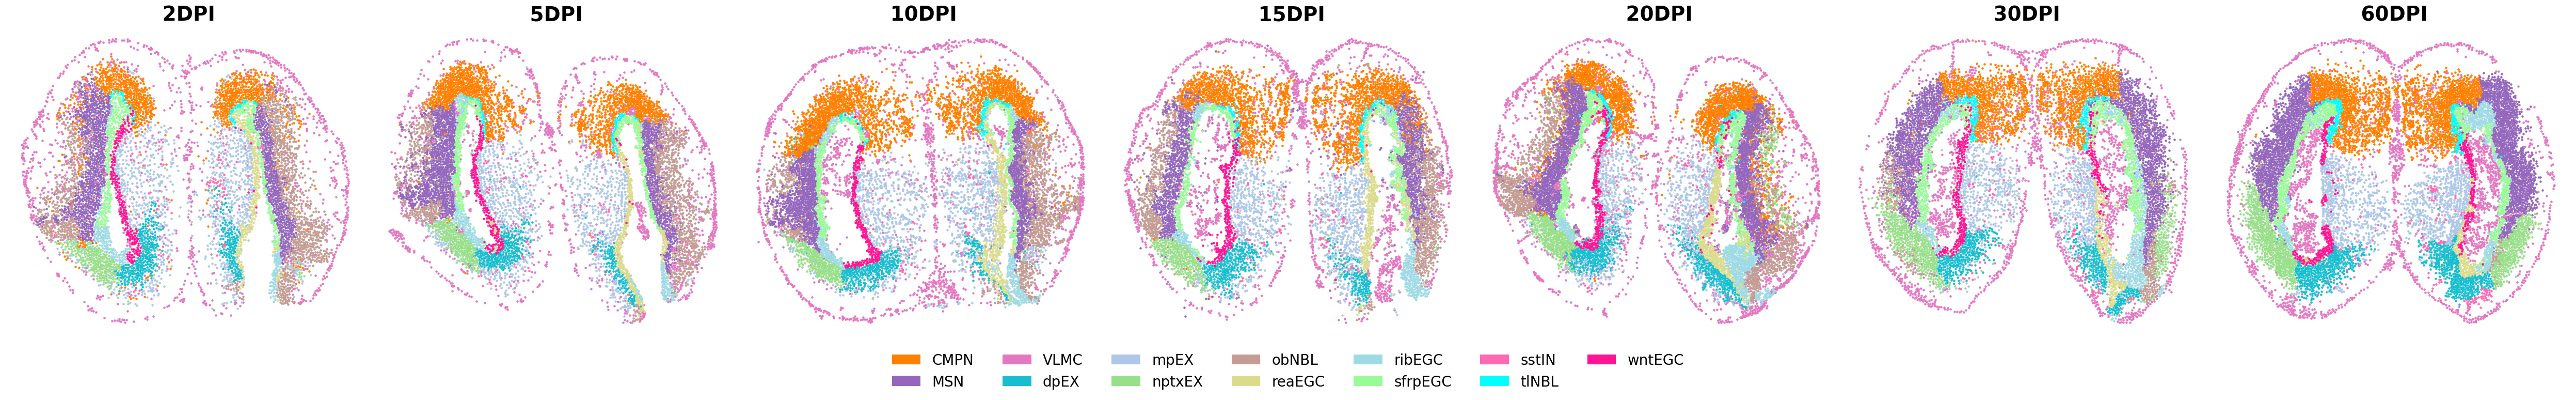

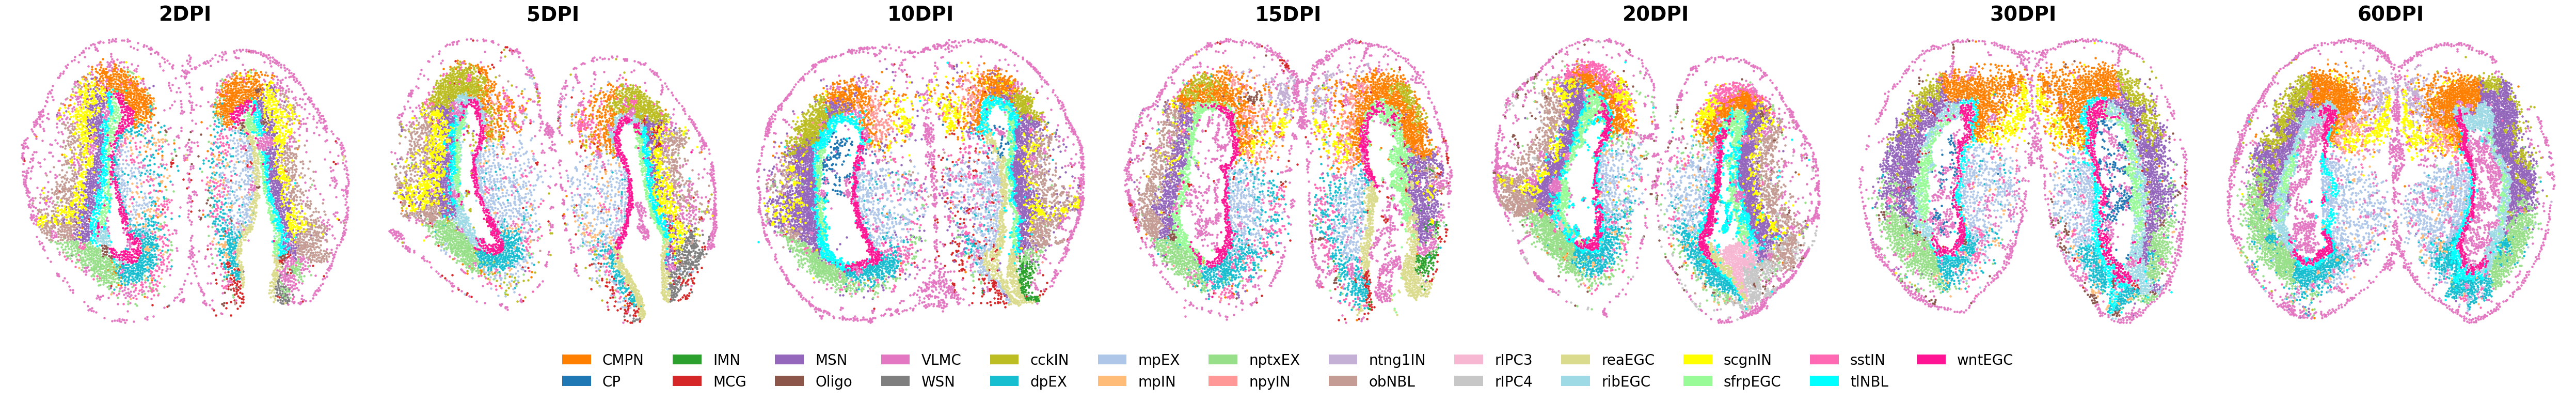

In [22]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from collections import defaultdict

def create_color_mapping(adata_list, annotation_key, adata_ST2Align, louvain_key):
    custom_colors = ['#FF7F00', '#1F77B4', '#2CA02C', '#D62728', '#9467BD', '#8C564B', '#E377C2', 
                     '#7F7F7F', '#BCBD22', '#17BECF', '#AEC7E8', '#FFBB78', '#98DF8A', '#FF9896', 
                     '#C5B0D5', '#C49C94', '#F7B6D2', '#C7C7C7', '#DBDB8D', '#9EDAE5', '#FFFF00', 
                     '#98FB98', '#FF69B4', '#00FFFF', '#FF1493', '#00FF00', '#FF00FF', '#1E90FF']
    
    celltype_list_A = np.unique([ann for adata in adata_list for ann in adata.obs[annotation_key]])
    celltype_list_E = adata_ST2Align.obs[louvain_key].cat.categories
    
    all_celltypes = np.unique(np.concatenate([celltype_list_A, celltype_list_E]))
    
    celltype_color_mapping = defaultdict(lambda: '#000000')  # Default to black if not matched
    
    for i, celltype in enumerate(all_celltypes):
        celltype_color_mapping[celltype] = custom_colors[i % len(custom_colors)]
    
    return celltype_color_mapping, celltype_list_A, celltype_list_E

def plot_spatial_clusters(adata_concat, section_ids, cluster_key='louvain', save_dir=None, color_mapping=None, celltype_list=None):
    if color_mapping is None or celltype_list is None:
        raise ValueError("color_mapping and celltype_list must be provided")

    fig, axs = plt.subplots(1, len(section_ids), figsize=(50, 5))
    
    for idx, batch in enumerate(section_ids):
        batch_data = adata_concat[adata_concat.obs['batch_names'] == batch]
        coordinatesA = batch_data.obsm['spatial'].copy()
        ax = axs[idx] if len(section_ids) > 1 else axs
        
        for ann in celltype_list:
            indices = batch_data.obs[cluster_key] == ann
            ax.scatter(coordinatesA[indices, 0], coordinatesA[indices, 1], s=5, 
                       c=[color_mapping[ann]], label=ann)
        
        ax.set_title(f" {section_ids[idx]}", fontsize=28, fontweight='bold')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)

    plt.tight_layout()

    # Create custom legend handles with rectangles
    legend_handles = [mpatches.Rectangle((0, 0), 1, 1, fc=color_mapping[ct]) for ct in celltype_list]

    # Calculate number of columns for 2 rows
    ncols = int(np.ceil(len(celltype_list) / 2))

    # Create legend at the bottom center with 2 rows
    fig.legend(legend_handles, celltype_list, loc='lower center', bbox_to_anchor=(0.5, -0.15), 
               ncol=ncols, fontsize=20, frameon=False, title_fontsize=14)

    # Adjust figure size to accommodate legend
    fig.set_size_inches(50, 7)  # Increased height to accommodate legend at the bottom

    if save_dir is not None:
        plt.savefig(save_dir, dpi=300, bbox_inches='tight')   
    plt.show()

# Create a consistent color mapping
adata_concat.obs["louvain_annotation"] = adata_concat.obs["louvain_annotation"].astype('category')
color_mapping, celltype_list_A, celltype_list_E = create_color_mapping(adata_list, "annotation", adata_concat, "louvain_annotation")

# Use this mapping for figE
plot_spatial_clusters(adata_concat, section_ids, cluster_key='louvain_annotation', 
                      color_mapping=color_mapping, celltype_list=celltype_list_E)

# For figA
fig, axs = plt.subplots(1, 7, figsize=(50, 5))
for i, adata in enumerate(adata_list):
    coordinatesA = adata.obsm['spatial'].copy()
    ax = axs[i]
    for ann in celltype_list_A:
        indices = adata.obs["annotation"] == ann
        ax.scatter(coordinatesA[indices, 0], coordinatesA[indices, 1], s=5, 
                   c=[color_mapping[ann]], label=ann)
    ax.set_title(section_ids[i], fontsize=28, fontweight='bold')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

plt.tight_layout()

legend_handles = [mpatches.Rectangle((0, 0), 1, 1, fc=color_mapping[ct]) for ct in celltype_list_A]
ncols = int(np.ceil(len(celltype_list_A) / 2))
fig.legend(legend_handles, celltype_list_A, loc='lower center', bbox_to_anchor=(0.5, -0.15), 
           ncol=ncols, fontsize=20, frameon=False, title_fontsize=14)

fig.set_size_inches(50, 7)
plt.show()

# More results

This demonstrates the basic workflow of STIFT for developmental and regenerative data. For additional STIFT integration examples and implementations, explore the complete source code in the [STIFT temporal alignment repository](https://github.com/TheLittleJimmy/temporal_alignment).